# Web Mining 

## Análisis de la oferta laboral en Argentina

### Etapa 2 - Aplicacion de técnicas de NLP:

A partir de los datos obtenidos, se realizan diversas tecnicas de NLP para obtener algunas conclusiones, y características de los puestos.

**INTRODUCCIÓN**

Para el trabajo final de la materia decidimos realizar un web scraping sobre una página de empleos. En nuestro caso en particular la www.randtad.com.ar . Previamente habíamos probado con páginas como Linkedin, pero las páginas mas populares para la búsqueda u ofrecimiento de empleo tiene distintas normas de seguridad que hace el procedimiento muy dificultoso por no decir impracticable.
    Decidimos utilizar la librería selenium y el explorador chrome para llevar adelante el scraping. Decidimos realizarlo en dos scripts diferentes. Uno para realizar el scrap y otro para analizar los datos. Esto es porque las modificaciones constantes que sufren las páginas web puede hacer que el primer script quede obsoleto. Por lo tanto agrupamos los datos en un archivo .csv para poder trabajar sobre los mismo y en todo caso modificar el primer script solamente.
    Posteriormente analizamos los datos y presentamos conclusiones.


#### Importacion librerias

In [ ]:
# Importación de las librerías necesarias

import pandas as pd 
import numpy as np
import matplotlib.pylab as plt
import wordcloud 
import re  
import string 
from collections import Counter
import selenium
from selenium.common.exceptions import NoSuchElementException, ElementClickInterceptedException
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import nltk
import nltk.corpus 
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.text import Text
from nltk.stem import LancasterStemmer
from nltk import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
import random
import time
from time import sleep
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

try:
    import spacy
    print("Libreria: 'spacy' esta instalada y se cargo correctamente")
except ModuleNotFoundError:
    print("Libreria: 'spacy' no esta instalada, se debe instalar")
    !pip install spacy
    import spacy
    
import es_core_news_sm 

import warnings
warnings.filterwarnings("ignore")

Libreria: 'spacy' esta instalada y se cargo correctamente


#### Etapa 3a: Análisis general del dataset 

Cargamos los datos obtenidos a partir del script de Web Scraping

**Preparación de los datos**

1. Como primer paso vamos a quitar la columna redundante en la numeración.

2. Establecer dos categorias para tipo de trabajo, tiempo completo o interim. Son pocas observaciones las que tiene el rango de salario, por lo tanto podemos calificarlas con "otro".

3. Dividir la columna de location en ciudad y provincia.

4. Quitar de la descripción del trabajo el mensaje que sale por default de la página.

In [2]:
df = pd.read_csv("df_allthepositions.csv")
df = df.drop(['Unnamed: 0'], axis=1)
df.rename(columns={'Job Title': 'Job_Title', 'Job Type':'Job_Type','Job Description':'Job_Description'}, inplace = True)
df

,Job_Title,Job_Type,Job_Description,Location
0,comercial agro.,tiempo completo,"['¡Esta propuesta te puede interesar!', 'En Ra...","necochea, buenos aires"
1,vendedor/ra de salón.,tiempo completo,"['¡Esta propuesta te puede interesar!', 'En Ra...","san juan, san juan"
2,vendedor/ra.,tiempo completo,"['¡Esta propuesta te puede interesar!', 'En Ra...","gualeguaychu, entre rios"
3,tax analyst.,tiempo completo,"['¡Esta propuesta te puede interesar!', 'En Ra...","capital federal, capital federal"
4,operario/a taller de muestra.,tiempo completo,"['¡Esta propuesta te puede interesar!', 'En Ra...","tortuguitas, buenos aires"
...,...,...,...,...
762,aparador/ra de calzados.,tiempo completo,"['¡Esta propuesta te puede interesar!', 'En Ra...","perez, santa fe"
763,maestranza.,tiempo completo,"['¡Esta propuesta te puede interesar!', 'En Ra...","maipu, mendoza"
764,maestranza /housekeeping.,tiempo completo,"['¡Esta propuesta te puede interesar!', 'En Ra...","tunuyan, mendoza"
765,operario/a de bodega.,tiempo completo,"['¡Esta propuesta te puede interesar!', 'En Ra...","maipu, mendoza"


**Obvservaciones**

Si se considera el tipo de trabajo se observa que existen categorías en modo texto como ser tiempo completo o tiempo parcial y en algunos casos en la misma celda la remuneración pretendida. En la descripción del puesto, en la mayoría de las observaciones comienza con un mensaje de la página de empleos que sería correcto quitar.  

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 767 entries, 0 to 766
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Job_Title        767 non-null    object
 1   Job_Type         767 non-null    object
 2   Job_Description  767 non-null    object
 3   Location         767 non-null    object
dtypes: object(4)
memory usage: 24.1+ KB


Valores de Job type:
tiempo completo                                     722
interim                                              34
$100,000 - $120,000, por mes, Sin Especificar         2
$265,000 - $0, por mes, Sin Especificar               2
$10,000 - $22,000, por mes, Sin Especificar           1
$250,000 - $0, por mes, Sin Especificar               1
$40,000 - $50,000, por mes, Sin Especificar           1
$2,000 - $3,000, por mes, Sin Especificar             1
$215,000 - $0, por mes, Sin Especificar               1
$40000.00 - $50000.00, por hora, Sin Especificar      1
$180,000 - $0, por mes, Sin Especificar               1
Name: Job_Type, dtype: int64
-------------------
Categorias nuevas:
tiempo completo    722
interim             34
SinEsp              11
Name: Job_Type, dtype: int64


<AxesSubplot:>

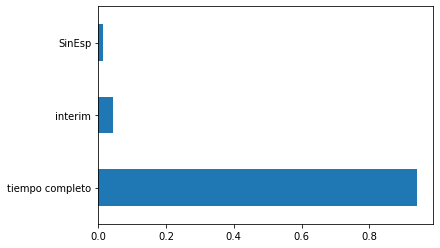

In [4]:
print("Valores de Job type:")
print(df.Job_Type.value_counts())

# Recategorización
otra_cat = (df.Job_Type!="tiempo completo") & (df.Job_Type!="interim")
df.loc[otra_cat,'Job_Type'] = 'SinEsp'

print("-------------------")

print("Categorias nuevas:")
print(df.Job_Type.value_counts())

df.Job_Type.value_counts(normalize=True).plot.barh()

**Se divide location en: City y Province.**

In [5]:
df[["City", "Province"]]= df.Location.str.split(pat= ",", n=1,expand=True)

# Remuevo espacios en blanco
df['Province'] = df['Province'].str.strip()
df['City'] = df['City'].str.strip()

# Reemplazo 
df['Province'] = df['Province'].replace('capital federal', "buenos aires")
df['Province'] = df['Province'].replace('', np.nan)

<AxesSubplot:>

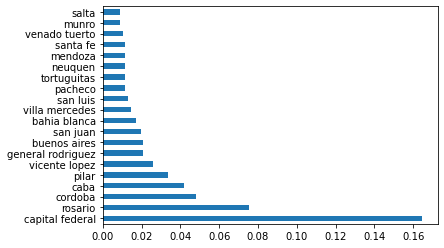

In [19]:
df.City.value_counts(normalize=True)[:20].plot.barh()

<AxesSubplot:>

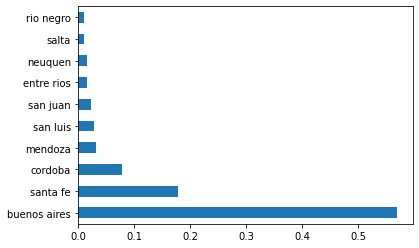

In [20]:
df.Province.value_counts()
df.Province.value_counts(normalize=True)[:10].plot.barh()

#### Etapa 3b : Selección de la columna Job Description

Se elimina la parte generica que habla sobre la empresa de Ranstad.

In [21]:
subcadena='¡Esta propuesta te puede interesar!\', \'En Randstad nos moviliza ayudar a las personas y a las organizaciones a desarrollar todo su potencial. Ese es el compromiso que asumimos como compañía en todo el mundo, un compromiso que nos impulsa a ir más allá para lograr que nuestros clientes y candidatos alcancen el éxito. ¿Cómo lo hacemos?, combinando nuestra pasión por las personas con el poder de la tecnología, creando experiencias más humanas, que nos permitan ser una fuente de inspiración y apoyo para quienes nos eligen. Porque estamos convencidos de que mejores personas hacen mejores empresas.\','
Job_desc=df.Job_Description
for i in range(0,len(Job_desc)):  
    if subcadena in Job_desc[i]:
        text=df.Job_Description[i].replace(subcadena, ' ')
        df.loc[i, "Job_Description"]=text

In [ ]:
df

##### Utilizando expresiones regulares se intenta limpiar el texto madiante la unificación del tipo de letra, eliminación de diversos símbolos, signos de puntuación, y palabras conteniendo números.

In [40]:
def  clean_text(df, text_field, new_text_field_name):
    "Make text lowercase, remove text in square brackets, some additional punctuation, remove punctuation and remove words containing numbers."
    df[new_text_field_name] = df[text_field].str.lower()
    df[new_text_field_name] = df[new_text_field_name].apply(lambda elem: re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", elem))  
    df[new_text_field_name] = df[new_text_field_name].apply(lambda elem: re.sub(r"\d+", "", elem))
    return df

##### Se limpia la columna "Job Title" y se genera una nueva columna, "Job Position" 

In [24]:
data_clean = clean_text(df, "Job_Title", "Job_Position")
data_clean.head()       

,Job_Title,Job_Type,Job_Description,Location,City,Province,Job_Position
0,comercial agro.,tiempo completo,"[' ' Tareas:', 'Ser el nexo entre productores...","necochea, buenos aires",necochea,buenos aires,comercial agro
1,vendedor/ra de salón.,tiempo completo,"[' 'Requisitos:', 'Nos encontramos en la búsq...","san juan, san juan",san juan,san juan,vendedorra de saln
2,vendedor/ra.,tiempo completo,[' 'Para importante comercio local dedicado a...,"gualeguaychu, entre rios",gualeguaychu,entre rios,vendedorra
3,tax analyst.,tiempo completo,[' ' Nos encontramos en la búsqueda de un Ana...,"capital federal, capital federal",capital federal,buenos aires,tax analyst
4,operario/a taller de muestra.,tiempo completo,[' ' Importante empresa del rubro construcci...,"tortuguitas, buenos aires",tortuguitas,buenos aires,operarioa taller de muestra


**Selección de la columna Job Description (derivada en la columna text_clean) para su análisis**

In [25]:
# Función Stopwords

#stopwords_spanish = nltk.corpus.stopwords.words('spanish')
new_stopword = ["n"]
stopwords_spanish2 = nltk.corpus.stopwords.words('spanish')
stopwords_spanish2.extend(new_stopword)

print(stopwords_spanish2)

['de', 'la', 'que', 'el', 'en', 'y', 'a', 'los', 'del', 'se', 'las', 'por', 'un', 'para', 'con', 'no', 'una', 'su', 'al', 'lo', 'como', 'más', 'pero', 'sus', 'le', 'ya', 'o', 'este', 'sí', 'porque', 'esta', 'entre', 'cuando', 'muy', 'sin', 'sobre', 'también', 'me', 'hasta', 'hay', 'donde', 'quien', 'desde', 'todo', 'nos', 'durante', 'todos', 'uno', 'les', 'ni', 'contra', 'otros', 'ese', 'eso', 'ante', 'ellos', 'e', 'esto', 'mí', 'antes', 'algunos', 'qué', 'unos', 'yo', 'otro', 'otras', 'otra', 'él', 'tanto', 'esa', 'estos', 'mucho', 'quienes', 'nada', 'muchos', 'cual', 'poco', 'ella', 'estar', 'estas', 'algunas', 'algo', 'nosotros', 'mi', 'mis', 'tú', 'te', 'ti', 'tu', 'tus', 'ellas', 'nosotras', 'vosotros', 'vosotras', 'os', 'mío', 'mía', 'míos', 'mías', 'tuyo', 'tuya', 'tuyos', 'tuyas', 'suyo', 'suya', 'suyos', 'suyas', 'nuestro', 'nuestra', 'nuestros', 'nuestras', 'vuestro', 'vuestra', 'vuestros', 'vuestras', 'esos', 'esas', 'estoy', 'estás', 'está', 'estamos', 'estáis', 'están', 'e

**Se remueven las stopwords en español**

In [52]:
data_clean['Job_Position'] = data_clean['Job_Position'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords_spanish2)]))

**Se remueven las custom_stopwords ("n")**

In [53]:
removing_custom_words = [words for words in data_clean if not words in stopwords_spanish2]
print(removing_custom_words)

['Job_Title', 'Job_Type', 'Job_Description', 'Location', 'City', 'Province', 'Job_Position', 'Job_Token', 'Job Token Lemma']


In [54]:
data_clean['Job_Position']

0                comercial agro
1               vendedorra saln
2                    vendedorra
3                   tax analyst
4      operarioa taller muestra
                 ...           
762         aparadorra calzados
763                  maestranza
764     maestranza housekeeping
765            operarioa bodega
766                   operarioa
Name: Job_Position, Length: 767, dtype: object

**Se tokenizan las frases obtenidas en la nueva columna**

In [55]:
data_clean['Job_Token'] = data_clean['Job_Position'].apply(lambda x: word_tokenize(x))

In [56]:
data_clean.head()

,Job_Title,Job_Type,Job_Description,Location,City,Province,Job_Position,Job_Token,Job Token Lemma
0,comercial agro.,tiempo completo,"[' ' Tareas:', 'Ser el nexo entre productores...","necochea, buenos aires",necochea,buenos aires,comercial agro,"[comercial, agro]","[comercial, agro]"
1,vendedor/ra de salón.,tiempo completo,"[' 'Requisitos:', 'Nos encontramos en la búsq...","san juan, san juan",san juan,san juan,vendedorra saln,"[vendedorra, saln]","[vendedorra, saln]"
2,vendedor/ra.,tiempo completo,[' 'Para importante comercio local dedicado a...,"gualeguaychu, entre rios",gualeguaychu,entre rios,vendedorra,[vendedorra],[vendedorra]
3,tax analyst.,tiempo completo,[' ' Nos encontramos en la búsqueda de un Ana...,"capital federal, capital federal",capital federal,buenos aires,tax analyst,"[tax, analyst]","[tax, analyst]"
4,operario/a taller de muestra.,tiempo completo,[' ' Importante empresa del rubro construcci...,"tortuguitas, buenos aires",tortuguitas,buenos aires,operarioa taller muestra,"[operarioa, taller, muestra]","[operarioa, taller, mostrar]"


In [57]:
import es_core_news_sm

nlp = spacy.load("es_core_news_sm")

In [58]:
data_clean['Job Token Lemma'] = "" 
for i in range(0, len(df)):
    corpus = []
    lema = nlp(data_clean['Job_Position'][i])
    for palabra in lema:
        corpus.append(palabra.lemma_.lower())        
        data_clean['Job Token Lemma'][i] = corpus

In [59]:
data_clean.head()

,Job_Title,Job_Type,Job_Description,Location,City,Province,Job_Position,Job_Token,Job Token Lemma
0,comercial agro.,tiempo completo,"[' ' Tareas:', 'Ser el nexo entre productores...","necochea, buenos aires",necochea,buenos aires,comercial agro,"[comercial, agro]","[comercial, agro]"
1,vendedor/ra de salón.,tiempo completo,"[' 'Requisitos:', 'Nos encontramos en la búsq...","san juan, san juan",san juan,san juan,vendedorra saln,"[vendedorra, saln]","[vendedorra, saln]"
2,vendedor/ra.,tiempo completo,[' 'Para importante comercio local dedicado a...,"gualeguaychu, entre rios",gualeguaychu,entre rios,vendedorra,[vendedorra],[vendedorra]
3,tax analyst.,tiempo completo,[' ' Nos encontramos en la búsqueda de un Ana...,"capital federal, capital federal",capital federal,buenos aires,tax analyst,"[tax, analyst]","[tax, analyst]"
4,operario/a taller de muestra.,tiempo completo,[' ' Importante empresa del rubro construcci...,"tortuguitas, buenos aires",tortuguitas,buenos aires,operarioa taller muestra,"[operarioa, taller, muestra]","[operarioa, taller, mostrar]"


#### Etapa 3c: Análisis exploratorio del corpus obtenido

##### Generacion de un Corpus con el contenido de la columna Job Description (derivada en text_clean, tokenizada y lematizada)

In [60]:
corpus = []
for i in range(0, len(df)  ):
    review = re.sub('[^a-zA-Z]', ' ', str(data_clean['Job Token Lemma'][i]))
    review = review.lower()
    review = review.split()
    review = ' '.join(review).replace('\u200b', ' ').replace('\n', ' ').split(' ') # Obtenemos una única lista de palabras como elementos
    #review = ' '.join(review)
    for word in review:
        corpus.append(word)

In [61]:
t = Text(corpus)
t

<Text: comercial agro vendedorra saln vendedorra tax analyst operarioa...>

##### Visualizamos los puestos más requeridos. Hacemos una gráfica de frecuencias y nube de palabras.

In [62]:
t.vocab()

FreqDist({'analista': 136, 'operarioa': 66, 'tcnicoa': 65, 'produccin': 44, 'sr': 38, 'comercial': 27, 'administrativoa': 27, 'n': 27, 'jefea': 27, 'ssr': 26, ...})

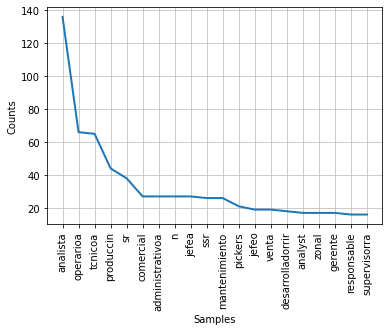

In [63]:
t.plot(20)

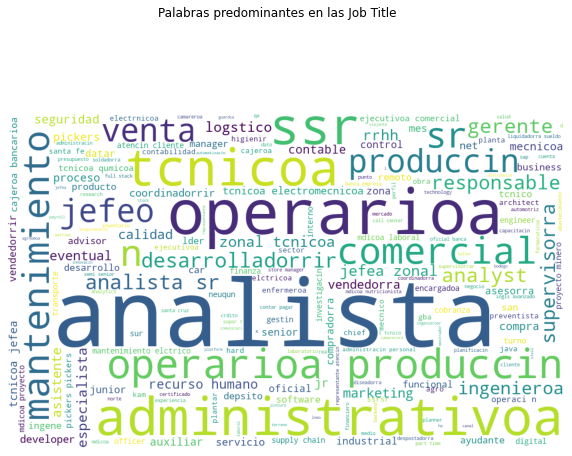

In [64]:
parrafos = [palabra for palabra in corpus]
wc = wordcloud.WordCloud(width = 1000,
                         height = 600,
                         background_color = 'white',
                         collocations = True,
                         ).generate_from_text(' '.join(parrafos))
fig, ax = plt.subplots(figsize = (10,8))
fig.suptitle('Palabras predominantes en las Job Title')
ax.imshow(wc)
ax.axis('off')

plt.show()

In [65]:
t.collocations()

jefea zonal; recurso humano; operarioa produccin; zonal tcnicoa;
cajeroa bancarioa; supply chain; atencin cliente; tcnicoa
electromecnicoa; proyecto minero; contar pagar; full stack; ingls
avanzado; liquidadorra sueldo; part time; tcnicoa qumicoa; mdicoa
laboral; administracin personal; call center; ejecutivoa comercial;
mantenimiento elctrico
